# Bitcoin Stock price Prediction using LSTM

# [](http://) Table of Content 
<hr style='height:2px'>

## 1. What is LSTM?
## 2. Importing Library
## 3. Loading Dataset
## 4. EDA
## 5. Building Model
## 6. Prediction
## 7. Evaluation 
## 8. Conclusion
<hr style='height:2px'>

# 1. What is LSTM ?

* ###  Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points, but also entire sequences of data.

* ### Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning.

* ### LSTMs are often referred to as fancy RNNs. Vanilla RNNs do not have a cell state. They only have hidden states and those hidden states serve as the memory for RNNs. Meanwhile, LSTM has both cell states and a hidden states.

# 2. Importing Library

In [1]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import pandas_ta as ta
import random
import datetime

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'iframe'  # or 'browser'

# 3. Loading Dataset

In [2]:
# Load our dataset 
# Note it should be in same dir
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'BTC-USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
maindf = tickerData.history(period='1d', start=start, end=end)

#change to YYYY-MM-DD format for parsing
maindf.index = maindf.index.strftime('%Y-%m-%d')

# Reset the index to convert the index into a column
maindf.reset_index(inplace=True)

# Drop the columns named 'Dividends' and 'Stock Splits' from 'maindf'
maindf.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
maindf['Adj Close'] = maindf['Close']


In [3]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  3522
Total number of fields present in the dataset:  7


In [4]:
maindf.shape

(3522, 7)

In [5]:
maindf.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,398.821014


In [6]:
maindf.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
3517,2024-05-04,62891.031250,64494.957031,62599.351562,63891.472656,20620477992,63891.472656
3518,2024-05-05,63892.453125,64610.890625,62955.304688,64031.132812,18296164805,64031.132812
3519,2024-05-06,64038.312500,65494.902344,62746.238281,63161.949219,28697928697,63161.949219
3520,2024-05-07,63162.761719,64390.457031,62285.980469,62334.816406,25930730982,62334.816406
3521,2024-05-09,61171.207031,61523.050781,61171.207031,61523.050781,25406515200,61523.050781


In [7]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3522 non-null   object 
 1   Open       3522 non-null   float64
 2   High       3522 non-null   float64
 3   Low        3522 non-null   float64
 4   Close      3522 non-null   float64
 5   Volume     3522 non-null   int64  
 6   Adj Close  3522 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 192.7+ KB


In [8]:
maindf.describe()

,Open,High,Low,Close,Volume,Adj Close
count,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03,3522.000000
mean,16118.648268,16494.337392,15716.063042,16135.070885,1.717863e+10,16135.070885
std,17880.309173,18305.636610,17407.839658,17893.168602,1.926265e+10,17893.168602
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,178.102997
25%,1026.250000,1046.025024,1003.097519,1027.364960,2.222202e+08,1027.364960
50%,8715.845703,8885.618652,8483.786133,8723.863281,1.290970e+10,8723.863281
75%,26926.460938,27342.624512,26617.527832,26957.068848,2.773924e+10,26957.068848
max,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11,73083.500000


# Checking for Null Values

In [9]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [10]:
print('NA values:',maindf.isnull().values.any())

NA values: False


In [11]:
# If dataset had null values we can use this code to drop all the null values present in the dataset

# maindf=maindf.dropna()
# print('Null Values:',maindf.isnull().values.sum())
# print('NA values:',maindf.isnull().values.any())

In [12]:
# Final shape of the dataset after dealing with null values 

maindf.shape

(3522, 7)

# 4. EDA(Exploratory Data Analysis)

In [13]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17
Ending Date 2024-05-09


/var/folders/qy/65s83jts4qg4cwsk9lj8n8n80000gn/T/ipykernel_24423/1507586809.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/qy/65s83jts4qg4cwsk9lj8n8n80000gn/T/ipykernel_24423/1507586809.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



#### StockPrice Analysis from Start

In [14]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2014 = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
100,2014-12-26,319.152008,331.424011,316.627014,327.924011
101,2014-12-27,327.583008,328.911011,312.630005,315.863007
102,2014-12-28,316.160004,320.028015,311.078003,317.239014
103,2014-12-29,317.700989,320.266998,312.307007,312.670013


In [15]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,412.654003,407.182428


 Note that we only have few months in 2014 so the rest of the months are **NaN**

In [16]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))
fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparison between Stock open and close price')
fig.show()


Note that we only have few months in 2014 so the rest of the months are not plotted since we do not have the data

In [17]:
y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2014.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

Note that we only have few months in 2014 so the rest of the months are not plotted since we do not have the data

In [18]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2014, x=y_2014.Date, y=[y_2014['Open'], y_2014['Close'], 
                                          y_2014['High'], y_2014['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2015

In [19]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2015 = maindf.loc[(maindf['Date'] >= '2015-01-01')
                     & (maindf['Date'] < '2016-01-01')]

y_2015.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
106,2015-01-01,320.434998,320.434998,314.002991,314.248993
107,2015-01-02,314.079010,315.838989,313.565002,315.032013
108,2015-01-03,314.846008,315.149994,281.082001,281.082001
109,2015-01-04,281.145996,287.230011,257.612000,264.195007
110,2015-01-05,265.084015,278.341003,265.084015,274.473999
...,...,...,...,...,...
466,2015-12-27,416.514008,424.006989,408.882996,422.822998
467,2015-12-28,423.342987,429.769012,418.480988,422.278992
468,2015-12-29,422.097992,432.983002,420.627014,432.983002
469,2015-12-30,433.299988,434.386993,422.084015,426.619995


In [20]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,251.799905,248.782547
February,232.821856,234.153645
March,269.278419,269.042259
April,235.708668,235.491534
May,237.161806,236.997001
June,236.941433,238.081766
July,278.857679,279.563740
August,252.986774,250.733805
September,233.486733,233.595533


In [21]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [22]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [23]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2016

In [24]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2016 = maindf.loc[(maindf['Date'] >= '2016-01-01')
                     & (maindf['Date'] < '2017-01-01')]

y_2016.drop(y_2016[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
471,2016-01-01,430.721008,436.246002,427.515015,434.334015
472,2016-01-02,434.622009,436.062012,431.869995,433.437988
473,2016-01-03,433.578003,433.743011,424.705994,430.010986
474,2016-01-04,430.061005,434.516998,429.084015,433.091003
475,2016-01-05,433.069000,434.182007,429.675995,431.959991
...,...,...,...,...,...
832,2016-12-27,908.354004,940.047974,904.255005,933.197998
833,2016-12-28,934.830994,975.921021,934.830994,975.921021
834,2016-12-29,975.125000,979.396973,954.502991,973.497009
835,2016-12-30,972.534973,972.534973,934.833008,961.237976


In [25]:
monthvise= y_2016.groupby(y_2016['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,412.805902,410.844485
February,402.304692,404.408274
March,417.262033,416.525774
April,433.487433,434.339398
May,459.237547,461.954415
June,638.544834,642.869061
July,662.977779,661.356103
August,581.238966,579.585197
September,604.614034,605.848633


In [26]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [27]:
y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2016.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [28]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2016, x=y_2016.Date, y=[y_2016['Open'], y_2016['Close'], 
                                          y_2016['High'], y_2016['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2017

In [29]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2017 = maindf.loc[(maindf['Date'] >= '2017-01-01')
                     & (maindf['Date'] < '2018-01-01')]

y_2017.drop(y_2017[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
837,2017-01-01,963.658020,1003.080017,958.698975,998.325012
838,2017-01-02,998.617004,1031.390015,996.702026,1021.750000
839,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966
840,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980
841,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005
...,...,...,...,...,...
1197,2017-12-27,16163.500000,16930.900391,15114.299805,15838.500000
1198,2017-12-28,15864.099609,15888.400391,13937.299805,14606.500000
1199,2017-12-29,14695.799805,15279.000000,14307.000000,14656.200195
1200,2017-12-30,14681.900391,14681.900391,12350.099609,12952.200195


In [30]:
monthvise= y_2017.groupby(y_2017['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,914.680971,914.916159
February,1055.620071,1062.533672
March,1133.212576,1129.365228
April,1197.646997,1206.641007
May,1865.748712,1895.383529
June,2630.573332,2636.204346
July,2509.213233,2519.418386
August,3819.812579,3880.989998
September,4077.400993,4064.836312


In [31]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [32]:
y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2017.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [33]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2017, x=y_2017.Date, y=[y_2017['Open'], y_2017['Close'], 
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2018

In [34]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2018 = maindf.loc[(maindf['Date'] >= '2018-01-01')
                     & (maindf['Date'] < '2019-01-01')]

y_2018.drop(y_2018[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1202,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
1203,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
1204,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
1205,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
1206,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000
...,...,...,...,...,...
1562,2018-12-27,3854.688477,3874.416992,3645.448486,3654.833496
1563,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701
1564,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691
1565,2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637


In [35]:
monthvise= y_2018.groupby(y_2018['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,13212.074219,13085.558090
February,9462.242920,9472.001151
March,9156.591718,9040.557097
April,7963.618311,8033.596631
May,8505.240675,8450.997732
June,6829.257975,6793.507666
July,7101.466450,7146.349987
August,6723.800955,6700.129946
September,6622.821338,6610.675033


In [36]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [37]:
y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2018.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [38]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2018, x=y_2018.Date, y=[y_2018['Open'], y_2018['Close'], 
                                          y_2018['High'], y_2018['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2019

In [39]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2019 = maindf.loc[(maindf['Date'] >= '2019-01-01')
                     & (maindf['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1567,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020
1568,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424
1569,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211
1570,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529
1571,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580
...,...,...,...,...,...
1927,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379
1928,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234
1929,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832
1930,2019-12-30,7420.272949,7454.824219,7276.308105,7292.995117


In [40]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,3709.705645,3701.554963
February,3697.178327,3711.907261
March,3967.740400,3976.069100
April,5136.813314,5178.469434
May,7205.208024,7309.694131
June,9339.480322,9415.900179
July,10691.706055,10669.336158
August,10657.745621,10643.248362
September,9858.141813,9814.067871


In [41]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [42]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [43]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'], 
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2020

In [44]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2020 = maindf.loc[(maindf['Date'] >= '2020-01-01')
                     & (maindf['Date'] < '2021-01-01')]

y_2020.drop(y_2020[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1932,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316
1933,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215
1934,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277
1935,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738
1936,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383
...,...,...,...,...,...
2293,2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922
2294,2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594
2295,2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500
2296,2020-12-30,27360.089844,28937.740234,27360.089844,28840.953125


In [45]:
monthvise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,8318.949597,8389.270476
February,9656.215113,9630.722185
March,6943.507009,6871.016113
April,7150.611328,7224.477327
May,9237.761530,9263.151745
June,9499.797005,9489.227214
July,9519.383852,9589.899729
August,11639.097215,11652.394185
September,10689.700163,10660.276855


In [46]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [47]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2020.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [48]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'], 
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2021

In [49]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-01-01')
                     & (maindf['Date'] < '2021-12-31')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2298,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344
2299,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578
2300,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438
2301,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062
2302,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688
...,...,...,...,...,...
2657,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625
2658,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969
2659,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469
2660,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938


In [50]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,34652.961694,34761.649950
February,45874.967215,46306.798968
March,54544.678175,54998.008695
April,57251.256250,57206.720052
May,47105.828503,46443.286668
June,35920.546940,35845.154687
July,34234.212450,34444.973790
August,45516.119834,45709.022681
September,46041.859375,45939.771484


In [51]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [52]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [53]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'], 
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2022

In [54]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2022 = maindf.loc[(maindf['Date'] >= '2022-01-01')
                     & (maindf['Date'] < '2023-01-01')]

y_2022.drop(y_2022[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2663,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500
2664,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750
2665,2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188
2666,2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219
2667,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906
...,...,...,...,...,...
3023,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828
3024,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266
3025,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797
3026,2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938


In [55]:
monthvise= y_2022.groupby(y_2022['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,41368.073463,41114.422379
February,40591.103934,40763.474051
March,41889.148438,41966.237525
April,41694.653646,41435.319661
May,31900.711127,31706.105217
June,24783.338477,24383.685482
July,21424.733052,21539.253843
August,22471.866557,22366.266318
September,19821.353711,19804.779232


In [56]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [57]:
y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2022.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [58]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2022, x=y_2022.Date, y=[y_2022['Open'], y_2022['Close'], 
                                          y_2022['High'], y_2022['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2023

In [59]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2023 = maindf.loc[(maindf['Date'] >= '2023-01-01')
                     & (maindf['Date'] < '2024-01-01')]

y_2023.drop(y_2023[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
3028,2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078
3029,2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703
3030,2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422
3031,2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281
3032,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328
...,...,...,...,...,...
3388,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469
3389,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469
3390,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344
3391,2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344


In [60]:
monthvise= y_2023.groupby(y_2023['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,20043.860131,20250.717490
February,23304.086007,23304.539202
March,24945.340411,25116.900895
April,28823.841732,28857.574544
May,27562.723160,27499.307145
June,27651.926758,27763.198437
July,30098.767578,30057.469947
August,27959.756615,27852.792843
September,26271.268229,26306.136393


In [61]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [62]:
y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2023.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [63]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2023, x=y_2023.Date, y=[y_2023['Open'], y_2023['Close'], 
                                          y_2023['High'], y_2023['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2024

In [64]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2024 = maindf.loc[(maindf['Date'] >= '2024-01-01')
                     & (maindf['Date'] < '2024-04-11')]

y_2024.drop(y_2015[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
3393,2024-01-01,42280.234375,44175.437500,42214.976562,44167.332031
3394,2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750
3395,2024-01-03,44961.601562,45503.242188,40813.535156,42848.175781
3396,2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875
3397,2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406
...,...,...,...,...,...
3489,2024-04-06,67840.570312,69629.601562,67491.718750,68896.109375
3490,2024-04-07,68897.109375,70284.429688,68851.632812,69362.554688
3491,2024-04-08,69362.554688,72715.359375,69064.242188,71631.359375
3492,2024-04-09,71632.500000,71742.507812,68212.921875,69139.015625


In [65]:
monthvise= y_2024.groupby(y_2024['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,42910.015373,42919.612399
February,49231.727101,49875.174300
March,67372.752394,67702.439264
April,68784.960938,68709.333984
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,NaN,NaN


In [66]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [67]:
y_2024.groupby(y_2024['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2024.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2024.groupby(y_2024['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [68]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2024, x=y_2024.Date, y=[y_2024['Open'], y_2024['Close'], 
                                          y_2024['High'], y_2024['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Overall Analysis from 2014-2024

In [69]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2014-09-17')
                     & (maindf['Date'] <= end)]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
3517,2024-05-04,62891.031250,64494.957031,62599.351562,63891.472656
3518,2024-05-05,63892.453125,64610.890625,62955.304688,64031.132812
3519,2024-05-06,64038.312500,65494.902344,62746.238281,63161.949219
3520,2024-05-07,63162.761719,64390.457031,62285.980469,62334.816406


In [70]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,16579.492690,16579.732894
February,18365.801165,18492.403748
March,21063.951157,21148.616195
April,21612.753859,21569.501019
May,16200.730032,16120.149506
June,13058.934120,13023.092093
July,12946.813125,12989.735743
August,14402.491680,14403.907037
September,13142.241365,13122.887938


In [71]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# 5. Building LSTM Model

* ## Here we are just considering 4 year data for training data 

* ## Since Bitcoin price has historically been in a 4 year cycle in parallel with its halving cycles. I have chosen to make the model learn past 4 years boom and bust cycle.

* ## As we want to predict Close Price of the Bitcoin so we are just Considering Close and Date  

In [72]:
# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (3522, 2)


### Now we will Take data of just 4 Years

In [73]:
four_years_ago = end - datetime.timedelta(days=4*365)
eight_years_ago = end - datetime.timedelta(days=8*365)
closedf = closedf[closedf['Date'] > four_years_ago]
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1459


In [74]:
closedf

,Date,Close
2063,2020-05-11,8601.795898
2064,2020-05-12,8804.477539
2065,2020-05-13,9269.987305
2066,2020-05-14,9733.721680
2067,2020-05-15,9328.197266
...,...,...
3517,2024-05-04,63891.472656
3518,2024-05-05,64031.132812
3519,2024-05-06,63161.949219
3520,2024-05-07,62334.816406


In [75]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

* ### Normalizing Data
- Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
- MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

In [76]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1459, 1)


* ### Slicing data into Training set and Testing set

In [77]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (875, 1)
test_data:  (584, 1)


* ### Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15   

In [78]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [79]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (859, 15)
y_train:  (859,)
X_test:  (568, 15)
y_test (568,)


In [80]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (859, 15, 1)
X_test:  (568, 15, 1)


* # Model Building

In [81]:
#remove randomness
#tf.keras.utils.set_random_seed(42)
#tf.config.experimental.enable_op_determinism()

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

/Users/jonathanchow/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [82]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1065 - val_loss: 0.0541
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0448 - val_loss: 0.0082
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0027
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

- ### Plotting Loss vs Validation loss 

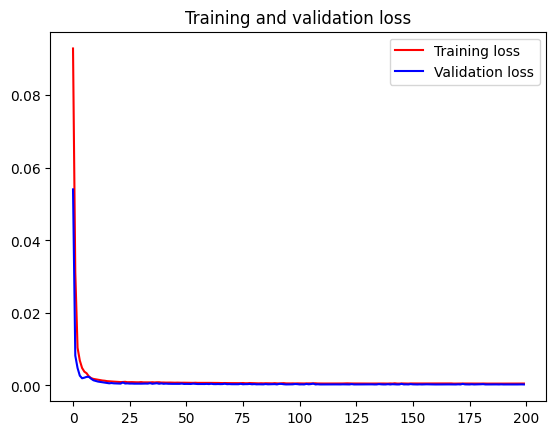

<Figure size 640x480 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [84]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


((859, 1), (568, 1))

- # Model Evaluation

In [85]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

- ## Evaluation metrices RMSE, MSE and MAE

In [86]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1443.0715143320294
Train data MSE:  2082455.3954765366
Train data MAE:  969.2100859920693
-------------------------------------------------------------------------------------
Test data RMSE:  1070.4908542271094
Test data MSE:  1145950.6689838863
Test data MAE:  674.8461948448507


- ## Variance Regression Score

In [87]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9922279964808765
Test data explained variance regression score: 0.9948480017215791


- ## R square score for regression

In [88]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9921725020531575
Test data R2 score: 0.9947774862314333


- ## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [89]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0014518955292404112
Test data MGD:  0.000765833690972427
----------------------------------------------------------------------
Train data MPD:  51.11119707801033
Test data MPD:  26.616259869391932


- # Comparision of original stock close price and predicted close price

In [90]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1459, 1)
Test predicted data:  (1459, 1)


- # Predicting next 30 days

In [91]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


- # Plotting last 15 days of dataset and next predicted 30 days

In [92]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [93]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



- # Plotting entire Closing Stock Price with next 30 days period of prediction

In [94]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()